In [1]:
import cv2

import matplotlib.pyplot as plt
from utils.letter_extraction import *

import numpy as np
import tensorflow as tf
import keras
from keras import layers, ops

2024-02-12 17:12:40.439511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:12:40.439587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:12:40.475520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 17:12:40.551904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 17:12:41.561227: W tensorflow/compiler/tf2

In [2]:
max_letters = 16
input_shape = (32,320)

In [3]:
def get_crop_boundaries(img, trashold=250):
    top = 0
    bottom =0
    left = 0
    right = 0
    for i in range(img.shape[0]):
        if img[i,:].mean() > trashold:
            top = i
        else:
            break
    for i in range(img.shape[0]):
        if img[-i,:].mean() > trashold:
            bottom = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,i].mean() > trashold:
            left = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,-i].mean() > trashold:
            right = i
        else:
            break
    left = max(1,left)
    right = max(1,right)
    top = max(1,top)
    bottom = max(1,bottom)

    return left, right, top, bottom

634 628 399 2013
(8005, 1342)


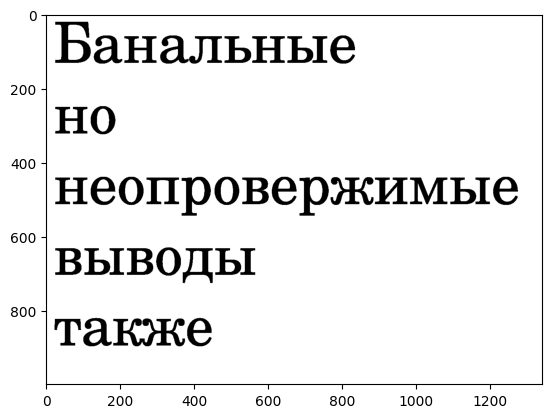

In [4]:
words_img_gr = cv2.imread('../data/words.png', 0)

l,r,t,b = np.array(get_crop_boundaries(words_img_gr, 254))-20
print(l,r,t,b)
if l<1:
    l=1
if r<1:
    r=1
if t<1:
    t=1
if b<1:
    b=1
words_img_gr = words_img_gr[t:-b,l:-r]

plt.imshow(words_img_gr[:1000], cmap='gray')
print(words_img_gr.shape)
plt.show()

(200, 1342)
(1, 456, 1, 16) (200, 1342)
16
(210, 1342)
(1, 1104, 18, 15) (210, 1342)
4
(210, 1342)
(1, 15, 19, 1) (210, 1342)
26
(210, 1342)
(1, 726, 20, 1) (210, 1342)
17
(210, 1342)
(1, 844, 20, 12) (210, 1342)
8
(210, 1342)
(1, 381, 21, 1) (210, 1342)
16
(210, 1342)
(1, 274, 22, 1) (210, 1342)
20
(210, 1342)
(1, 370, 23, 1) (210, 1342)
17
(210, 1342)
(1, 876, 27, 8) (210, 1342)
6
(210, 1342)
(1, 500, 1, 1) (210, 1342)
18
(210, 1342)
(1, 255, 1, 1) (210, 1342)
19
(210, 1342)
(1, 364, 1, 1) (210, 1342)
17
(210, 1342)
(1, 1180, 31, 6) (210, 1342)
2
(210, 1342)
(1, 244, 1, 1) (210, 1342)
25
(210, 1342)
(1, 661, 1, 1) (210, 1342)
10
(210, 1342)
(1, 1111, 31, 1) (210, 1342)
3
(210, 1342)
(1, 1026, 32, 1) (210, 1342)
5
(210, 1342)
(1, 567, 33, 1) (210, 1342)
12
(210, 1342)
(1, 481, 34, 1) (210, 1342)
16
(210, 1342)
(1, 656, 1, 1) (210, 1342)
9
(210, 1342)
(1, 201, 36, 1) (210, 1342)
21
(210, 1342)
(1, 221, 1, 1) (210, 1342)
20
(210, 1342)
(1, 733, 1, 1) (210, 1342)
12
(210, 1342)
(1, 668, 

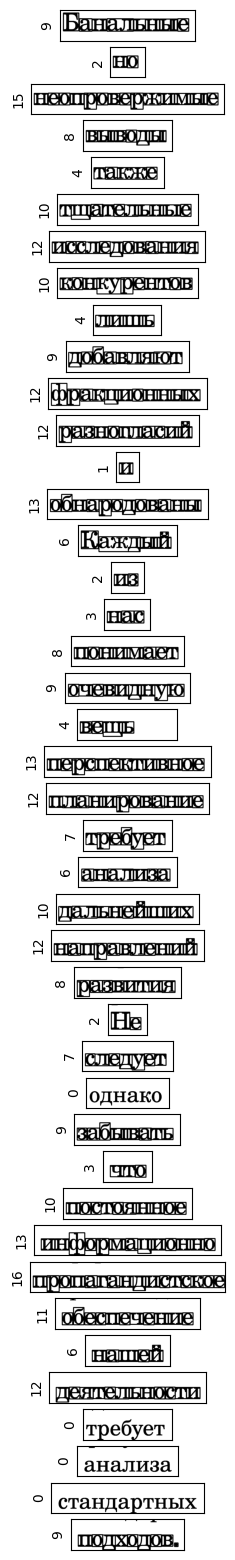

In [5]:
num_words = 42
threshold = 254
line_h = int(words_img_gr.shape[0]/num_words)

words_data = []
bb_data = []



fig, ax = plt.subplots(nrows=num_words, ncols=1, figsize=(20,20))
for i in range(num_words):
    t = max(0,line_h*(i)-10)
    b = min(words_img_gr.shape[0], line_h*(i+1)+10)
    
    img = words_img_gr[t:b,:]
    print(img.shape)
    
    l,r,t,b = np.array(get_crop_boundaries(img, threshold))-50
    
    
    if t+b>=img.shape[0]//2:
        t=b=1
    if l+r>=img.shape[1]:
        l=r=1
    if l<1:
        l=1
    if r<1:
        r=1
    if t<1:
        t=1
    if b<1:
        b=1
    
    
    print((l,r,t,b), img.shape)

    img = img[:,l:-r]
    
    orig = img.copy()
    words_data.append(img[:,:,np.newaxis].copy())
    
    
    
    img = cv2.erode(img, np.ones((3,3), np.uint8)*255, iterations=1)
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    print(len(contours))

    hir = hierarchy[0, :, 3]
    
    inner_conts = []
    
    output = np.zeros_like(img.copy())+255
    box = []
    for idx, contour in enumerate(contours):
        if hir[idx] == 0:
            (x, y, w, h) = cv2.boundingRect(contour)
            box.append((x, y, w, h))
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 0), 5) 
            inner_conts.append(contour)
    bb_data.append(box)
    ax[i].imshow(cv2.drawContours(np.zeros_like(img)+255, contours, -1, (0,0,0), 1), cmap='gray')
    ax[i].imshow(orig, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(len(box))

In [6]:
def prepare_word_image(word, target_shape=input_shape):

    h,w = word.shape[:2]
        
    if w >= h * (target_shape[1]/target_shape[0]):
        high = w * (target_shape[0]/target_shape[1])
        width = w
    else:
        high = h
        width = h * (target_shape[1]/target_shape[0])
    
    high = int(high)
    width = int(width)
    
    blank = np.zeros((high, width), dtype=np.uint8)+255
    
    if h<high:
        y_pos = (high-h)//2
    else:
        y_pos = 0    
    
    blank[y_pos:y_pos+h,:w]=word[:,:,0]
    
    img = cv2.resize(blank, (target_shape[1],target_shape[0]) , interpolation=cv2.INTER_AREA)
    
    return img

def prepare_bb_data(bb_list, max_len=max_letters):
    num_bb = len(bb_list)
    new_bb_list = bb_list.copy()
    if num_bb < max_len:
        new_bb_list += [(0,0,0,0)]*(max_len-num_bb)
    return new_bb_list

In [7]:
words_data1 =np.array(list(map(prepare_word_image, words_data)))
words_data1.shape

(42, 32, 320)

In [8]:
bb_data1 = np.array(list(map(prepare_bb_data, bb_data)))
bb_data1.shape

(42, 16, 4)

In [9]:
from utils.augmenters import MultipleAugmenter, BlurAugmenter

blur = BlurAugmenter()

aug = MultipleAugmenter(list(words_data1.copy()), 
                        list(bb_data1.copy()),         
                        augmenters = [BlurAugmenter(0.99),
                                      BlurAugmenter(0.7)],
                        augment_args = [[3],[5]])
aug.random_augment(5)

42
119
312
839
2257


In [10]:
np.array(aug.images).shape

(6065, 32, 320)

In [11]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
x_data.shape

(6065, 32, 320, 1)

In [12]:
y_data = np.array(aug.captions)
y_data.shape

(6065, 16, 4)

In [41]:
patch_size = (8, 8)  # 2-by-2 sized patches

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

def patch_extract(images):
    print(tf.shape(images))
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    print(tf.shape(patches))
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

In [42]:
patch_extract(x_data[0:100])

tf.Tensor([100  32 320   1], shape=(4,), dtype=int32)
tf.Tensor([100   4  40  64], shape=(4,), dtype=int32)


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 1024000 values, but the requested shape has 102400 [Op:Reshape]

In [28]:
dataset = (
    tf.data.Dataset.from_tensor_slices((x_data, (y_data[:,:,0],y_data[:,:,1],y_data[:,:,2],y_data[:,:,3])))    
    .batch(batch_size=32)
    .map(lambda im, res: (patch_extract(im), res))
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 64), dtype=tf.float64, name=None), (TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None)))>

In [15]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers, ops

from utils.funcs import window_partition, window_reverse


@tf.keras.utils.register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(
            self,
            dim,
            window_size,
            num_heads,
            qkv_bias=True,
            dropout_rate=0.0,
            **kwargs,
    ):
        super().__init__(**kwargs)

        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate

        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
                2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

    def get_config(self):
        config = super().get_config()

        config.update({"dim": self.dim,
                       "window_size": self.window_size,
                       "num_heads": self.num_heads,
                       "qkv_bias": self.qkv_bias,
                       "dropout_rate": self.dropout_rate,
                       })
        return config


@tf.keras.utils.register_keras_serializable()
class SwinTransformer(layers.Layer):
    def __init__(
            self,
            dim,
            num_patch,
            num_heads,
            window_size=7,
            shift_size=0,
            num_mlp=1024,
            qkv_bias=True,
            dropout_rate=0.2,
            **kwargs,
    ):
        super().__init__(**kwargs)

        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate
        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=self.num_heads,
            qkv_bias=self.qkv_bias,
            dropout_rate=self.dropout_rate,
        )
        self.drop_path = layers.Dropout(self.dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(self.dropout_rate),
                layers.Dense(dim),
                layers.Dropout(self.dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

    def get_config(self):
        config = super().get_config()

        config.update({"dim": self.dim,
                       "num_patch": self.num_patch,
                       "num_heads": self.num_heads,
                       "window_size": self.window_size,
                       "shift_size": self.shift_size,
                       "num_mlp": self.num_mlp,
                       "qkv_bias": self.qkv_bias,
                       "dropout_rate": self.dropout_rate,
                       })
        return config


@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)

    def get_config(self):
        config = super().get_config()

        config.update({"embed_dim": self.embed_dim,
                       "num_patch": self.num_patch,
                       })
        return config


@tf.keras.utils.register_keras_serializable()
class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

    def get_config(self):
        config = super().get_config()

        config.update({"embed_dim": self.embed_dim,
                       "num_patch": self.num_patch,
                       })
        return config


In [31]:
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[1] // patch_size[1]
num_patch_y = input_shape[0] // patch_size[0]

learning_rate = 1e-3
batch_size = 32
num_epochs = 200
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [32]:
num_patch_y, num_patch_x 

(4, 40)

In [33]:
input = layers.Input(shape=(160, 4))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
dense = keras.layers.Dense(1024, activation='relu')(x)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)

bb_x = keras.layers.Dense(max_letters, activation="sigmoid", name='x')(dense)

bb_y = keras.layers.Dense(max_letters, activation="sigmoid", name='y')(dense)

bb_w = keras.layers.Dense(max_letters, activation="sigmoid", name='w')(dense)

bb_h = keras.layers.Dense(max_letters, activation="sigmoid", name='h')(dense)
model = keras.Model(input, [bb_x, bb_y, bb_w, bb_h])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 160, 4)    │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ patch_embedding_4   │ (None, 160, 64)   │  10,560 │ input_layer_8[0][0]  │
│ (PatchEmbedding)    │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ swin_transformer_4  │ (None, 160, 64)   │  50,072 │ patch_embedding_4[0… │
│ (SwinTransformer)   │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ swin_transformer_5  │ (None, 160, 64)   │  50,712 │ swin_transformer_4[… │
│ (SwinTransformer)   │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ patch_merging_2     │ (None, 40, 128)   │  32,768 │ swin_transformer_5[… │
│ (PatchMerging)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 128)       │       0 │ patch_merging_2[0][… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_39 (Dense)    │ (None, 1024)      │ 132,096 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_40 (Dense)    │ (None, 512)       │ 524,800 │ dense_39[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_41 (Dense)    │ (None, 256)       │ 131,328 │ dense_40[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ x (Dense)           │ (None, 16)        │   4,112 │ dense_41[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ y (Dense)           │ (None, 16)        │   4,112 │ dense_41[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ w (Dense)           │ (None, 16)        │   4,112 │ dense_41[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ h (Dense)           │ (None, 16)        │   4,112 │ dense_41[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 948,784 (3.62 MB)

 Trainable params: 948,112 (3.62 MB)

 Non-trainable params: 672 (5.25 KB)

In [20]:
model.compile(optimizer='adam', loss='mse')

In [23]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta = 1e-1,
                              patience=20, min_lr=1e-8)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=10, start_from_epoch=30)
checkpoint_filepath = f"tmp/SWIN2_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
    )

callbacks = [reduce_lr, checkpoint_callback]

In [27]:
his = model.fit(dataset, shuffle=True, epochs=1000, callbacks=callbacks)

Epoch 1/1000


ValueError: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 160, 4), found shape=(None, 16, 64)